First part of this notebook is a copy of 2.4.4 challenge - make your own regression model

In [1]:
import numpy as np
import pandas as pd
from scipy import stats
from sklearn import linear_model
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
from statsmodels.stats import diagnostic
from scipy.stats import normaltest, boxcox
import math

In [2]:
ny_crime = pd.read_excel('table_8_offenses_known_to_law_enforcement_new_york_by_city_2013.xls')
ny_crime.head()

,Table 8,Unnamed: 1,Unnamed: 2,Unnamed: 3,Unnamed: 4,Unnamed: 5,Unnamed: 6,Unnamed: 7,Unnamed: 8,Unnamed: 9,Unnamed: 10,Unnamed: 11,Unnamed: 12
0,NEW YORK,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,Offenses Known to Law Enforcement,NaN,NaN,NaN,NaN,,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,"by City, 2013",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,City,Population,Violent\ncrime,Murder and\nnonnegligent\nmanslaughter,Rape\n(revised\ndefinition)1,Rape\n(legacy\ndefinition)2,Robbery,Aggravated\nassault,Property\ncrime,Burglary,Larceny-\ntheft,Motor\nvehicle\ntheft,Arson3
4,Adams Village,1861,0,0,NaN,0,0,0,12,2,10,0,0


In [3]:
ny_crime = pd.read_excel('table_8_offenses_known_to_law_enforcement_new_york_by_city_2013.xls')
ny_crime.columns = ny_crime.iloc[3]
ny_crime.drop([0,1,2,3,352,353,354], inplace=True) #drop header and footer info
ny_crime.index = ny_crime['City']

ny_crime['Aggravated\nassault']
# only focus on columns of interest
ny_crime_coi = ny_crime[['Aggravated\nassault','Property\ncrime','Population', 'Murder and\nnonnegligent\nmanslaughter', 'Robbery', 'Larceny-\ntheft']] 

# change column dtypes to numeric
for col in ny_crime_coi:
    ny_crime_coi[col] = pd.to_numeric(ny_crime_coi[col])

# New York is the huge outlier in the data so we'll drop it for the purposes of this exercise
ny_crime_coi.drop('New York', inplace=True)

features = ny_crime_coi[['Property\ncrime','Population']]
features['Population^2'] = features['Population'].apply(lambda x: x**2)
features['Murder_binary'] = np.where(ny_crime_coi['Murder and\nnonnegligent\nmanslaughter']>0,1,0)
features['Robbery_binary'] = np.where(ny_crime_coi['Robbery']>0,1,0)

features.head()

c:\python36-32\lib\site-packages\ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if sys.path[0] == '':
c:\python36-32\lib\site-packages\ipykernel_launcher.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  from ipykernel import kernelapp as app
c:\python36-32\lib\site-packages\ipykernel_launcher.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
c:

3,Property crime,Population,Population^2,Murder_binary,Robbery_binary
City,,,,,
Adams Village,12,1861,3463321,0,0
Addison Town and Village,24,2577,6640929,0,0
Akron Village,16,2846,8099716,0,0
Albany,4090,97956,9595377936,1,1
Albion Village,223,6388,40806544,0,1


## Original model 
(features engineered as instructed from curriculum)

In [4]:
# Instantiate and fit our model.
regr = linear_model.LinearRegression()
Y = features['Property\ncrime']
X = features[['Population','Population^2','Murder_binary','Robbery_binary']]
regr.fit(X, Y)

# Inspect the results.
print('\nCoefficients: \n', regr.coef_)
print('\nIntercept: \n', regr.intercept_)
print('\nR-squared:')
print(regr.score(X, Y))

# Extract predicted values.
predicted = regr.predict(X).ravel()
actual = Y

# Calculate the error, also called the residual.
residual = actual - predicted


print('\nresidual normal test now (pval): ', normaltest(residual)[1])
print( '\nresidual homoscedasticity test now (pval): ', diagnostic.het_breuschpagan(residual, predicted.reshape(len(predicted),1))[3])



Coefficients: 
 [  1.29510871e-02   1.14920528e-07   1.95038666e+02   9.28205845e+01]

Intercept: 
 -16.8158663217

R-squared:
0.844493761117

residual normal test now (pval):  2.39544701769e-86

residual homoscedasticity test now (pval):  1.53734156124e-30


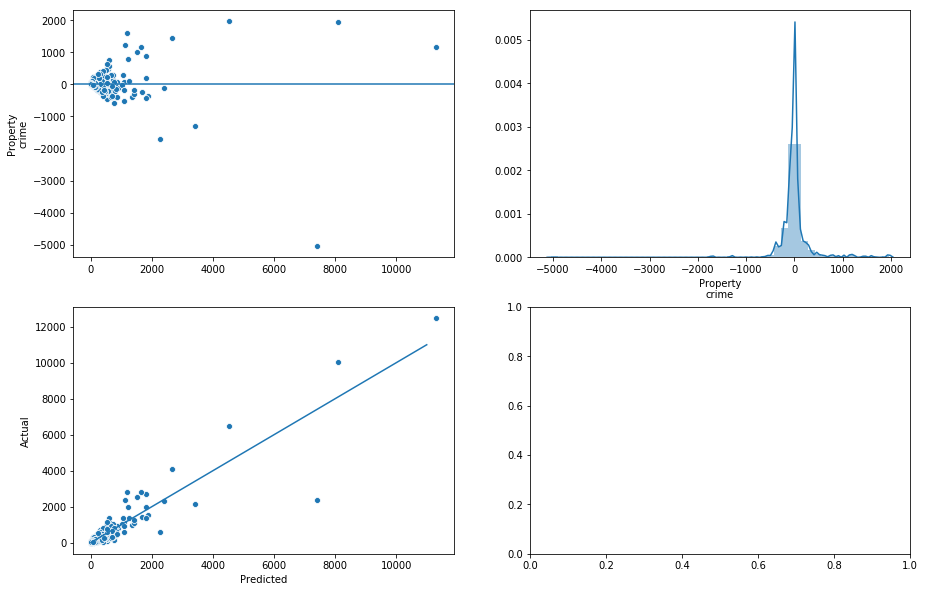

In [5]:

fig, axes = plt.subplots(2, 2, figsize=(15,10))

sns.scatterplot(predicted, residual, ax=axes[0][0])
axes[0][0].axhline(y=0)
     
sns.distplot(residual, ax=axes[0][1])

sns.scatterplot(predicted, actual, ax=axes[1][0])
axes[1][0].set(xlabel='Predicted', ylabel='Actual')
axes[1][0].plot([0,11000],[0,11000])

# residuals are skewed left and not homoscedastic

NormaltestResult(statistic=1.3376722253908575, pvalue=0.51230449562720226)


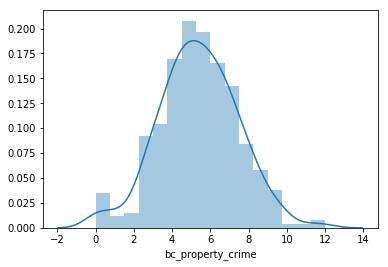

In [6]:
# box cox transformation on bc_property_crime
features['bc_property_crime'] = boxcox(features['Property\ncrime']+1)[0]

box_cox_lambda = boxcox(features['Property\ncrime']+1)[1] # we will need this later for testing

print(normaltest(features['bc_property_crime']))
sns.distplot(features['bc_property_crime'])

In [7]:
def root_transform(series, target):
    ''' finds best (highest r2 value) root transformation for series
        returns:
            1) transformed pandas series
            2) power to which original series was raised to obtain transformed series
            3) r2 value of transformed series vs dependent variable
    '''
    pwr=.99
    step = .01
    prev_r2 = -1
    current_r2 = stats.pearsonr(series, target)[0]**2
    
    while prev_r2 < current_r2:        
        prev_r2 = current_r2
        current_r2 = stats.pearsonr(series**pwr, target)[0]**2
        step = .01
        pwr -= step
    pwr += step
    
    # returns transformed pandas series, the power to which the original series was raised
    return (series**pwr, pwr, prev_r2)

r squared = 0.7596656201239537
power = 0.019999999999999248


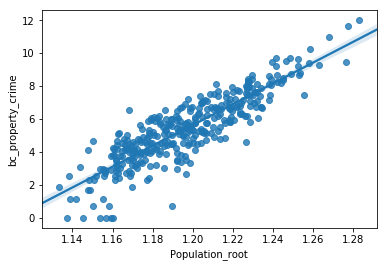

In [8]:
# transform population
features['Population_root'], population_root_pwr, r2 = root_transform(features['Population'], features['bc_property_crime'])
sns.regplot(data=features, x='Population_root', y='bc_property_crime')

print('r squared = {}\npower = {}'.format(r2, population_root_pwr))

r squared = 0.6961702747463085
power = 0.2099999999999993


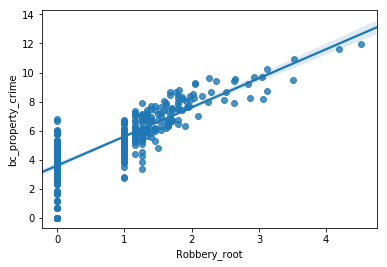

In [9]:
# transform Robbery
features['Robbery_root'], robbery_root_pwr, r2 = root_transform(ny_crime_coi['Robbery'], features['bc_property_crime'])
sns.regplot(data=features, x='Robbery_root', y='bc_property_crime')

print('r squared = {}\npower = {}'.format(r2, robbery_root_pwr))

r squared = 0.2806463271356509
power = 0.28999999999999937


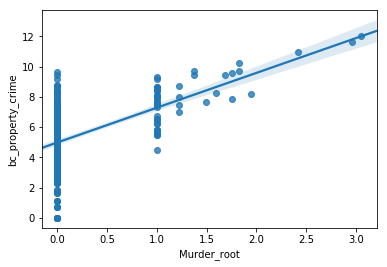

In [10]:
# transform Murder
features['Murder_root'], murder_root_pwr, r2 = root_transform(ny_crime_coi['Murder and\nnonnegligent\nmanslaughter'], features['bc_property_crime'])


sns.regplot(data=features, x='Murder_root', y='bc_property_crime')

print('r squared = {}\npower = {}'.format(r2, murder_root_pwr))

In [11]:
murder_root_pwr

0.28999999999999937

r squared = 0.6737809677414435
power = 0.23999999999999932


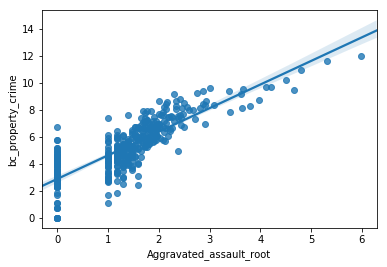

In [12]:
# transform Aggravated assault
features['Aggravated_assault_root'], aggravated_assault_root_pwr, r2 = root_transform(ny_crime_coi['Aggravated\nassault'], features['bc_property_crime'])
sns.regplot(data=features, x='Aggravated_assault_root', y='bc_property_crime')


print('r squared = {}\npower = {}'.format(r2, aggravated_assault_root_pwr))

In [13]:
# Instantiate and fit our model.
regr = linear_model.LinearRegression()
Y = features['bc_property_crime']
X = features[['Population_root','Robbery_root', 'Murder_root', 'Aggravated_assault_root']]
regr.fit(X, Y)

# Inspect the results.
print('\nCoefficients: \n', regr.coef_)
print('\nIntercept: \n', regr.intercept_)
print('\nR-squared:')
print(regr.score(X, Y))

# Extract predicted values.
predicted = regr.predict(X).ravel()
actual = Y

# Calculate the error, also called the residual.
residual = actual - predicted


print('\nresidual normal test now (pval): ', normaltest(residual)[1])
print( '\nresidual homoscedasticity test now (pval): ', diagnostic.het_breuschpagan(residual, predicted.reshape(len(predicted),1))[3])



Coefficients: 
 [ 34.62934923   0.68644238  -0.37982439   0.61967315]

Intercept: 
 -37.4634136883

R-squared:
0.847617929129

residual normal test now (pval):  3.89051351808e-09

residual homoscedasticity test now (pval):  1.137810661e-13


In [14]:
X.corr()
# significant multicollinearity present

3,Population_root,Robbery_root,Murder_root,Aggravated_assault_root
3,,,,
Population_root,1.000000,0.776122,0.531064,0.749043
Robbery_root,0.776122,1.000000,0.620757,0.795487
Murder_root,0.531064,0.620757,1.000000,0.638709
Aggravated_assault_root,0.749043,0.795487,0.638709,1.000000


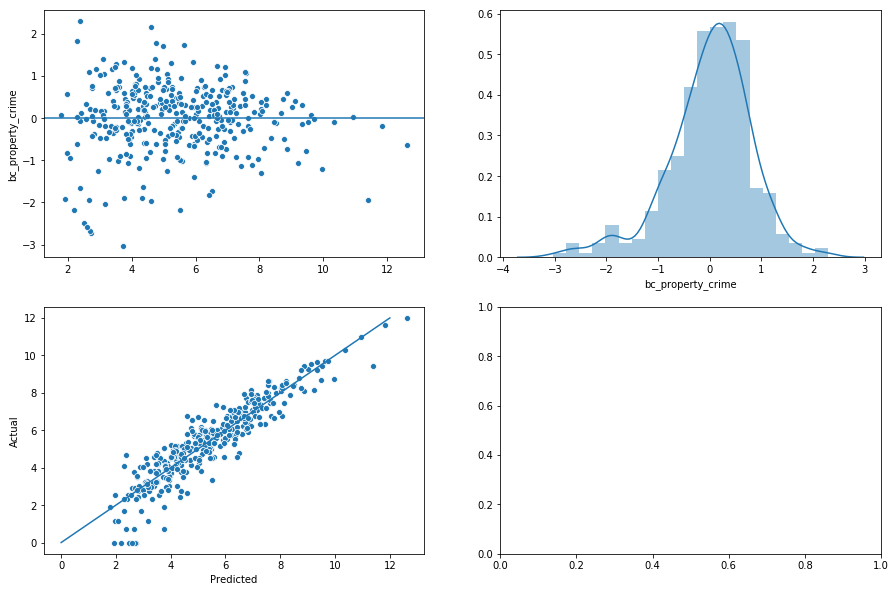

In [15]:
fig, axes = plt.subplots(2, 2, figsize=(15,10))

sns.scatterplot(predicted, residual, ax=axes[0][0])
axes[0][0].axhline(y=0)
     
sns.distplot(residual, ax=axes[0][1])

sns.scatterplot(predicted, actual, ax=axes[1][0])
axes[1][0].set(xlabel='Predicted', ylabel='Actual')
axes[1][0].plot([0,12],[0,12])

# residuals are more normal and more homoscedastic than the original model

## Feature engineering overview

### Original Model:
    - Predicted value: 
        - Property Crime
    - Features: 
        - Population
        - Population (squared)
        - Murder (binary)
        - Robbery (binary)

### New Model:
    - Predicted value : 
        - Property Crime (box cox transformed)
    - Features : 
        - Population (root transformed)
        - Murder (root transformed
        - Robbery (root transformed)
        - Aggravated assault (root transformed)


The new model applied a box cox transformation to the predicted values in order to achieve more normally distributed predicted values. The new model took the three base features from the original model (population, murder, robbery) and applied the root transformation that resulted in the most explained variance when regressed against the predicted value. Aggravated assault was also root transformed and added as a feature. The new model resulted in only a small increase in explained variance, but its residuals were both more normally distributed and more homoscedastic.

# \*\*\*\*\*\*\*\*\* 2.5.2 Challenge: Validating a linear regression \*\*\*\*\*\*\*\*\*\*\*\*
### Validating regression models for prediction
Statistical tests are useful for making sure a model is a good fit to the test data, and that all the features are useful to the model. However, to make sure a model has good predictive validity for new data, it is necessary to assess the performance of the model on new datasets.

The procedure is the same as what you learned in the Naive Bayes lesson – the holdout method and cross-validation method are both available. You've already had experience writing code to run these kinds of validation models for Naive Bayes: now you can try it again with linear regression. In this case, your goal is to achieve a model with a consistent R2 and only statistically significant parameters across multiple samples.

We'll use the property crime model you've been working on with, based on the FBI:UCR data. Since your model formulation to date has used the entire New York State 2013 dataset, you'll need to validate it using some of the other crime datasets available at the FBI:UCR website. Options include other states crime rates in 2013 or crime rates in New York State in other years or a combination of these.

### Iterate
Based on the results of your validation test, create a revised model, and then test both old and new models on a new holdout or set of folds.

Include your model(s) and a brief writeup of the reasoning behind the validation method you chose and the changes you made to submit and review with your mentor.

In [16]:
import statsmodels.formula.api as smf
from statsmodels.sandbox.regression.predstd import wls_prediction_std

linear_formula = 'bc_property_crime ~ Population_root+Robbery_root+Murder_root+Aggravated_assault_root'

lm = smf.ols(formula=linear_formula, data=features).fit()

print(lm.rsquared, '\n')
print(lm.params, '\n')
print(lm.pvalues)

0.847617929129 

Intercept                 -37.463414
Population_root            34.629349
Robbery_root                0.686442
Murder_root                -0.379824
Aggravated_assault_root     0.619673
dtype: float64 

Intercept                  1.471981e-29
Population_root            2.892325e-33
Robbery_root               4.958594e-12
Murder_root                2.147769e-03
Aggravated_assault_root    5.888416e-13
dtype: float64


Murder by itself had a positive correlation with property crime. It shouldn't have a negative coefficient in the model. This is likely due to multicollinearity with the other features. Let's remove murder from the model

In [17]:
linear_formula = 'bc_property_crime ~ Population_root+Robbery_binary+Aggravated_assault_root'

lm = smf.ols(formula=linear_formula, data=features).fit()

print(lm.rsquared, '\n')
print(lm.params, '\n')
print(lm.pvalues)

0.849870724045 

Intercept                 -39.120643
Population_root            35.916410
Robbery_binary              0.860998
Aggravated_assault_root     0.722507
dtype: float64 

Intercept                  6.606728e-35
Population_root            1.660388e-38
Robbery_binary             1.174948e-13
Aggravated_assault_root    9.513254e-23
dtype: float64


using Robbery_binary as a feature instead of Robbery_root seems to be better. It is also simpler which may help avoid overfitting. Let's test the new model's predictive power

In [18]:
from sklearn.model_selection import cross_val_score

def display_score(model, X, Y, cv=10):
    score = cross_val_score(model, X, Y, cv=10)
    print('accuracy = {} +/- {}'.format(round(score.mean(),4), round(score.std()*2,4)))

In [19]:
# Instantiate and fit our model.
regr = linear_model.LinearRegression()
Y = features['bc_property_crime']
X = features[['Population_root','Robbery_binary', 'Aggravated_assault_root']]
regr.fit(X, Y)

# Inspect the results.
print('\nCoefficients: \n', regr.coef_)
print('\nIntercept: \n', regr.intercept_)
print('\nR-squared:')
print(regr.score(X, Y))
display_score(regr, X, Y)

# Extract predicted values.
predicted = regr.predict(X).ravel()
actual = Y

# Calculate the error, also called the residual.
residual = actual - predicted


print('\nresidual normal test now (pval): ', normaltest(residual)[1])
print( '\nresidual homoscedasticity test now (pval): ', diagnostic.het_breuschpagan(residual, predicted.reshape(len(predicted),1))[3])




Coefficients: 
 [ 35.91640985   0.86099765   0.72250666]

Intercept: 
 -39.1206425184

R-squared:
0.849870724045
accuracy = 0.8267 +/- 0.1565

residual normal test now (pval):  5.02235374019e-07

residual homoscedasticity test now (pval):  2.67134322095e-14


In [20]:
# Try our model on the following year's crime data

ny_crime_14 = pd.read_excel('Table_8_Offenses_Known_to_Law_Enforcement_by_New_York_by_City_2014.xls')
ny_crime_14.head()

ny_crime_14.columns = ny_crime_14.iloc[3]

ny_crime_14.drop([i for i in range(373,len(ny_crime_14))], inplace=True) # drop footer info

ny_crime_14.drop([0,1,2,3], inplace=True) # drop header info
ny_crime_14.index = ny_crime_14['City']

# drop huge outlier NYC
ny_crime_14.drop('New York4', inplace=True)

# drop cities w/ zero property crime (there are only 4) to avoid error with box cox formula 
zero_pc = list(ny_crime_14[ny_crime_14['Property\ncrime']==0].index)
ny_crime_14.drop(zero_pc, inplace=True)

ny_crime_14

3,City,Population,Violent crime,Murder and nonnegligent manslaughter,Rape (revised definition)1,Rape (legacy definition)2,Robbery,Aggravated assault,Property crime,Burglary,Larceny- theft,Motor vehicle theft,Arson3
City,,,,,,,,,,,,,
Adams Village,Adams Village,1851,0,0,NaN,0,0,0,11,1,10,0,0
Addison Town and Village,Addison Town and Village,2568,2,0,NaN,0,1,1,49,1,47,1,0
Afton Village4,Afton Village4,820,0,0,0,NaN,0,0,1,0,1,0,0
Akron Village,Akron Village,2842,1,0,NaN,0,0,1,17,0,17,0,0
Albany4,Albany4,98595,802,8,54,NaN,237,503,3888,683,3083,122,12
Albion Village4,Albion Village4,5872,26,0,3,NaN,2,21,204,41,159,4,0
Alexandria Bay Village4,Alexandria Bay Village4,1107,0,0,0,NaN,0,0,7,2,5,0,0
Alfred Village4,Alfred Village4,4032,11,1,1,NaN,0,9,30,6,24,0,0
Altamont Village4,Altamont Village4,1723,1,0,0,NaN,0,1,2,2,0,0,0


In [21]:
data_2014 = pd.DataFrame()
data_2014['Property crime'] = pd.to_numeric(ny_crime_14['Property\ncrime'])

In [22]:
# box cox transformation with the lambda from original model
data_2014['bc_property_crime'] = boxcox(data_2014['Property crime'],lmbda=box_cox_lambda)

c:\python36-32\lib\site-packages\scipy\stats\morestats.py:1029: RuntimeWarning: invalid value encountered in less_equal
  if any(x <= 0):


In [23]:
# perform same transformation on test data
data_2014['Population_root']= pd.to_numeric(ny_crime_14['Population']**population_root_pwr)
data_2014['Robbery_root']= pd.to_numeric(ny_crime_14['Robbery']**robbery_root_pwr)
data_2014['Murder_root']= pd.to_numeric(ny_crime_14['Murder and\nnonnegligent\nmanslaughter']**murder_root_pwr)
data_2014['Aggravated_assault_root']= pd.to_numeric(ny_crime_14['Aggravated\nassault']**aggravated_assault_root_pwr)

data_2014['Murder_binary'] = np.where(ny_crime_14['Murder and\nnonnegligent\nmanslaughter']>0,1,0)
data_2014['Robbery_binary'] = np.where(ny_crime_14['Robbery']>0,1,0)

In [24]:
data_2014.dropna(inplace=True)

In [25]:
from functools import reduce
def display_equation(linear_model, X, Y):
    equation_parts = ['{} = '.format(Y.name)]
    
    for i, coef in enumerate(linear_model.coef_):
        equation_parts.append('({}*{}) + '.format(round(coef, 4), X.columns[i]))
        
    equation_parts.append('{}'.format(round(linear_model.intercept_, 4)))
    print(reduce(lambda x, y: x+y, equation_parts))


In [26]:
Y_test = data_2014['bc_property_crime']
X_test = data_2014[['Population_root','Robbery_binary','Aggravated_assault_root']]


# Inspect the results.
display_equation(regr, X, Y)
print('\n', regr.score(X_test, Y_test))

# Extract predicted values.
predicted = regr.predict(X_test).ravel()
actual = Y_test

# Calculate the error, also called the residual.
residual = actual - predicted


print('\nresidual normal test now (pval): ', normaltest(residual)[1])
print( '\nresidual homoscedasticity test now (pval): ', diagnostic.het_breuschpagan(residual, predicted.reshape(len(predicted),1))[3])


bc_property_crime = (35.9164*Population_root) + (0.861*Robbery_binary) + (0.7225*Aggravated_assault_root) + -39.1206

 0.796549650637

residual normal test now (pval):  0.000154330481047

residual homoscedasticity test now (pval):  5.44504860546e-13


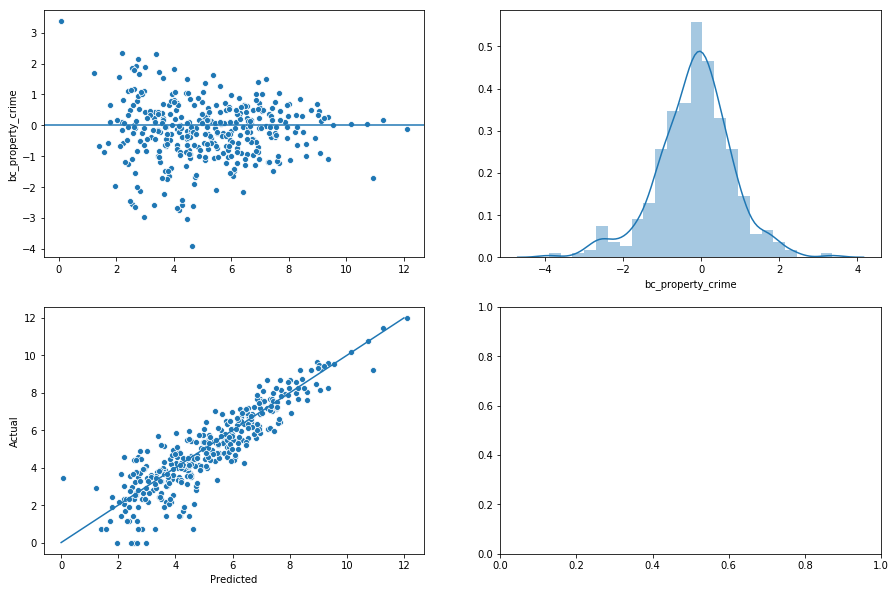

In [27]:
# a negative r2 value is not a good sign, let's investigate what's going on.
fig, axes = plt.subplots(2, 2, figsize=(15,10))

sns.scatterplot(predicted, residual, ax=axes[0][0])
axes[0][0].axhline(y=0)
     
sns.distplot(residual, ax=axes[0][1])

sns.scatterplot(predicted, actual, ax=axes[1][0])
axes[1][0].set(xlabel='Predicted', ylabel='Actual')
axes[1][0].plot([0,12],[0,12])

The model performed reasonably well on the following year's data. 

## LLLLLLLLLLLLLLLLLLLLLLLLLLLLLLLLLLLLLLLLLLLLLLLLLLLLLLLLLLLLLLLLLLLLLLL